## We choose a window of 60 time steps
## We want to learn 50 steps and predict 1 steps.
## Each step = 1 second

In [55]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Exploration

In [2]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(932400, 6)


pos.x     pos.y     pos.z   heading  velocity  weather
0 -77.030670 -1.283448  0.294200 -1.568362  7.056001        2
1 -77.030670 -1.283448  0.061311 -1.568362  7.172558        2
2 -77.029778 -1.283539 -0.030319 -1.568443  1.053028        2
3 -77.028854 -1.283728 -0.023681 -1.568593  0.883579        2
4 -77.008575 -1.288779  0.003869 -1.572756  1.548891        2

In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

932400


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932400 entries, 0 to 932399
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   pos.x       932400 non-null  float64
 1   pos.y       932400 non-null  float64
 2   pos.z       932400 non-null  float64
 3   heading     932400 non-null  float64
 4   velocity    932400 non-null  float64
 5   weather     932400 non-null  int64  
 6   Minute sin  932400 non-null  float64
 7   Minute cos  932400 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 56.9 MB


In [8]:
data.head()

pos.x     pos.y     pos.z   heading  velocity  weather    Minute sin  \
0 -77.030670 -1.283448  0.294200 -1.568362  7.056001        2 -1.792514e-08   
1 -77.030670 -1.283448  0.061311 -1.568362  7.172558        2  1.045284e-01   
2 -77.029778 -1.283539 -0.030319 -1.568443  1.053028        2  2.079117e-01   
3 -77.028854 -1.283728 -0.023681 -1.568593  0.883579        2  3.090170e-01   
4 -77.008575 -1.288779  0.003869 -1.572756  1.548891        2  4.067366e-01   

   Minute cos  
0    1.000000  
1    0.994522  
2    0.978148  
3    0.951057  
4    0.913545

### Windowing
We choose a window of 60 time steps
We want to learn 50 steps and predict 1 steps.

In [9]:
window_size = 60
grouped_data = windowing_array(data, window_size)

In [10]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

15540
60
8


### Slice and Split sequence 

In [11]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [12]:
x_train_init.shape, x_test_init.shape

((12432, 60, 8), (3108, 60, 8))

In [13]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence(x_train_init)

In [14]:
x_train.shape, y_train.shape

((12432, 59, 8), (12432, 1, 8))

In [15]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [16]:
y_train.shape

(12432, 1, 2)

In [ ]:
#y_train

In [17]:
y_train = y_train.reshape((-1, y_train.shape[-1]))

In [ ]:
#y_train

In [18]:
y_train.shape

(12432, 2)

In [19]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence(x_test_init)

In [20]:
x_test.shape, y_test.shape

((3108, 59, 8), (3108, 1, 8))

In [21]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [22]:
y_test.shape

(3108, 1, 2)

In [23]:
y_test = y_test.reshape((-1, y_test.shape[-1]))

In [24]:
y_test.shape

(3108, 2)

### Model Configuration

In [25]:
input_shape = x_train.shape[1:]
input_shape

(59, 8)

In [26]:
outout_shape = y_train.shape[1:]
outout_shape

(2,)

In [27]:
output_features_nr = len(y_train[1])
output_features_nr

2

### Train and evaluate

In [29]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [30]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_nr=output_features_nr, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [31]:
epochs = 20
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/20
311/311 [==============================] - 39s 111ms/step - loss: 1588.5701 - mae: 26.4464 - val_loss: 291.7386 - val_mae: 10.4382 - lr: 0.0010
Epoch 2/20
311/311 [==============================] - 34s 108ms/step - loss: 528.2369 - mae: 16.3818 - val_loss: 268.3448 - val_mae: 9.7571 - lr: 0.0010
Epoch 3/20
311/311 [==============================] - 33s 107ms/step - loss: 478.0595 - mae: 15.5816 - val_loss: 270.8909 - val_mae: 9.2443 - lr: 0.0010
Epoch 4/20
311/311 [==============================] - 34s 109ms/step - loss: 457.7899 - mae: 15.1619 - val_loss: 274.4259 - val_mae: 9.5953 - lr: 0.0010
Epoch 5/20
311/311 [==============================] - 35s 112ms/step - loss: 444.6207 - mae: 14.8956 - val_loss: 270.7312 - val_mae: 9.4993 - lr: 0.0010
Epoch 6/20
311/311 [==============================] - 36s 116ms/step - loss: 449.0303 - mae: 14.9167 - val_loss: 268.5009 - val_mae: 9.3232 - lr: 0.0010
Epoch 7/20
311/311 [==============================] - 36s 116ms/step - loss: 438

In [ ]:
#model.summary()

In [32]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

98/98 [==============================] - 4s 37ms/step - loss: 216.0629 - mae: 8.3236
Test accuracy 8.323639869689941
Test loss 216.0628662109375


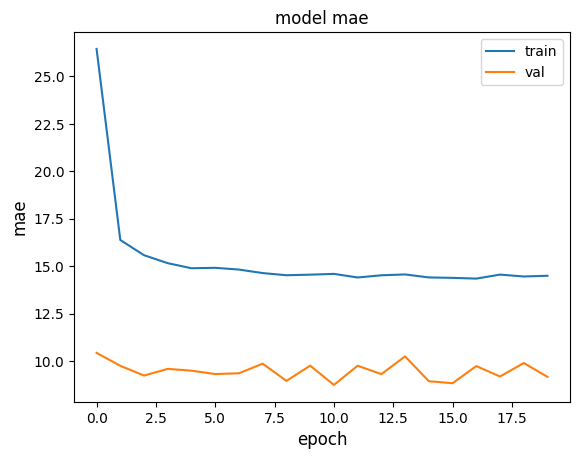

In [33]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [34]:
predictions = model.predict(x_test)

98/98 [==============================] - 4s 35ms/step


In [35]:
predictions.shape

(3108, 2)

In [47]:
predictions[10][1]

120.01645

In [52]:
y_test[10][1]

121.94569396972656

Visualize some few predictions


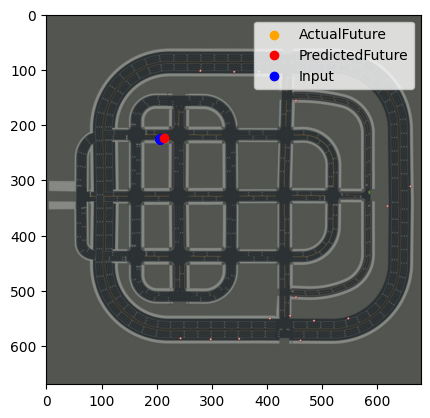

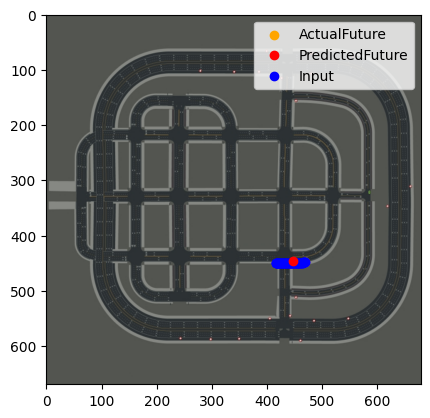

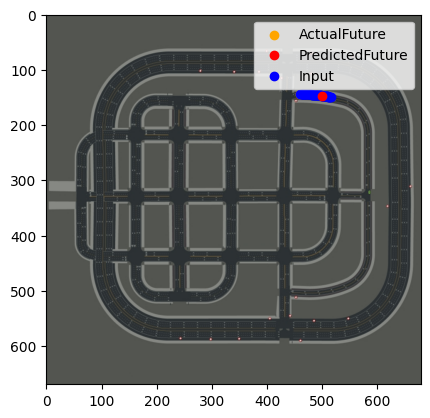

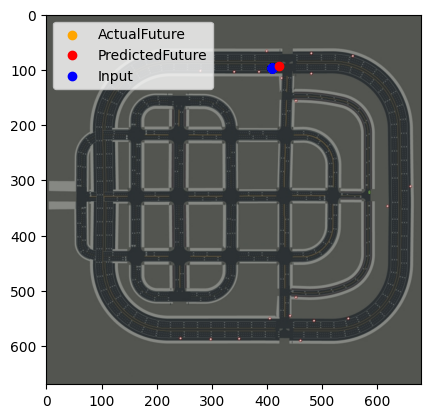

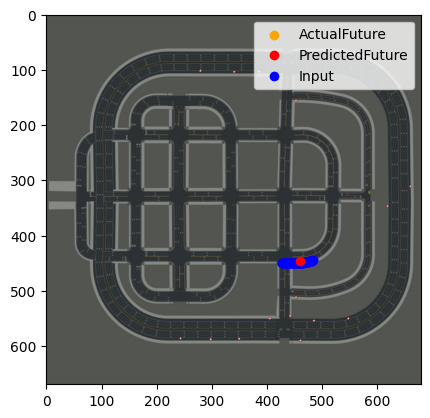

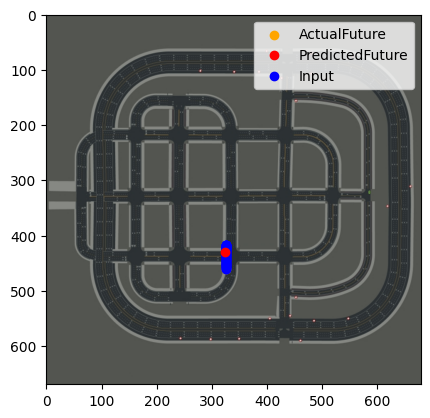

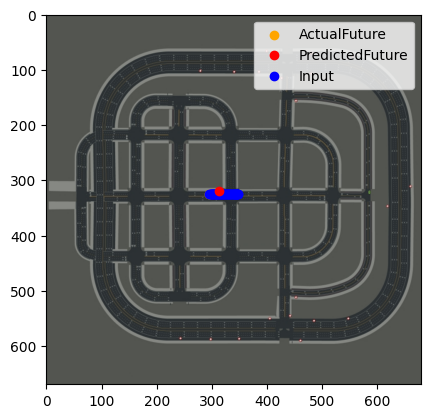

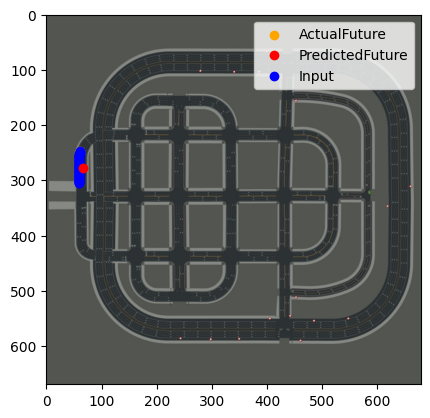

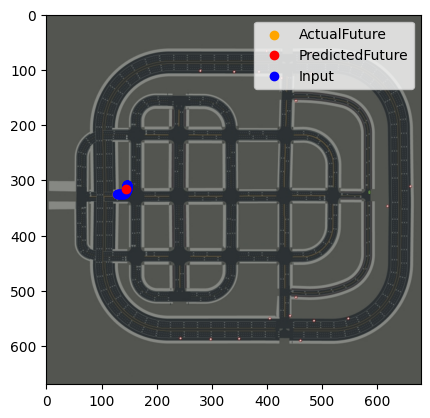

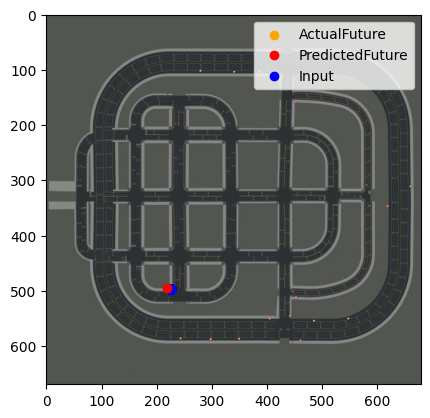

In [56]:
import random
from configs.utils_2 import plot_pred


print("Visualize some few predictions")

# After finding the best prediction, visualize it
if x_test is not None and y_test is not None and predictions is not None:
    # This visualization will now only show the best prediction example
    for item in range(0, 10):
        index = random.randint(0, len(x_test[:, :, :2]))
        plot_pred(x_test[:, :, :2][index], y_test[index], predictions[index])

## Explainer

### LIME

In [36]:
from lime import lime_tabular

In [37]:
explainer = lime_tabular.RecurrentTabularExplainer(
    x_train, 
    training_labels=y_train, 
    feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"],
    discretize_continuous=True,
    class_names=['pos.x', 'pos.y'],
    discretizer='decile')

In [38]:
exp = explainer.explain_instance(x_test[50], model.predict, num_features=10, labels=(0,))
exp.show_in_notebook()

157/157 [==============================] - 6s 37ms/step


/home/ab000840/.local/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


In [39]:
exp = explainer.explain_instance(x_test[50], model.predict, num_features=10, labels=(1,))
exp.show_in_notebook()

157/157 [==============================] - 6s 37ms/step


/home/ab000840/.local/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""
